<a href="https://colab.research.google.com/github/Yuvaraj0001/EVA7_Assignments/blob/main/Session%205/Step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
1. Set the architecture to reduce the parameters under 10k.
2. Get Consitent Accuracy 99.4% / reduce fluctuations.

# Result
1. No of Parameters - 9.5k
2. Highest Train Accuracy -98.49
3. Highest test Accuracy - 99.52

# Analysis
1. Reduced the dropout to 0.03
2. The accuracy is consistent
3. Applied Step lr to reduce fluctuations and Image Augmentation Techniques

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)), 
                                       transforms.ColorJitter(brightness=0.40, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# How did we get those mean and std values which we used above?


In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model

In [12]:
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 22, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing


In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [15]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.1531488001346588 Batch_id=468 Accuracy=78.34: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]



Test set: Average loss: 0.0510, Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.1240365132689476 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]



Test set: Average loss: 0.0456, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.0439520888030529 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:52<00:00,  8.94it/s]



Test set: Average loss: 0.0299, Accuracy: 9916/10000 (99.16%)

EPOCH: 3


Loss=0.057043593376874924 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]



Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.19094546139240265 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]



Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.026827408000826836 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s]



Test set: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.03887273371219635 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.09850376099348068 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s]



Test set: Average loss: 0.0267, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.07194086164236069 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]



Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.09153598546981812 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]



Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

EPOCH: 10


Loss=0.08988592028617859 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:52<00:00,  8.94it/s]



Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 11


Loss=0.05541469529271126 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:52<00:00,  8.97it/s]



Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.0784502625465393 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]



Test set: Average loss: 0.0158, Accuracy: 9950/10000 (99.50%)

EPOCH: 13


Loss=0.05853532254695892 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:52<00:00,  8.96it/s]



Test set: Average loss: 0.0159, Accuracy: 9952/10000 (99.52%)

EPOCH: 14


Loss=0.1017845869064331 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]



Test set: Average loss: 0.0165, Accuracy: 9950/10000 (99.50%)



Text(0.5, 1.0, 'Test Accuracy')

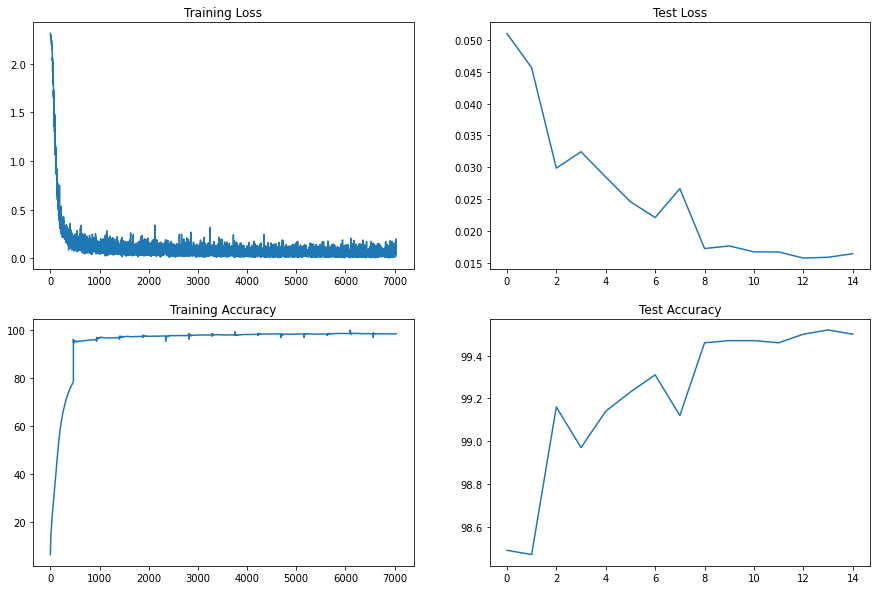

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")